# Landscape of RTE expression
This script is used to check the sanity of the data, corresponding to Figure 2 and Supplemental Figure S1A,B <br>
Author: Wankun Deng
Email: dengwankun@hotmail.com
GitHub: https://github.com/wkdeng

In [ ]:
%load_ext rpy2.ipython
import os
os.chdir('/home/wdeng3/workspace/Codespace/scRTE/scripts')
from common import *
## time comsuming, memory comsuming
load_sc_data()

In [ ]:
%%R
if(getwd()!='/home/wdeng3/workspace/Codespace/scRTE/scripts'){
    setwd('/home/wdeng3/workspace/Codespace/scRTE/scripts')
}
source('common.r')

## Distribution on genome

In [10]:
## Length distribution
class_len=rmsk.loc[rmsk['repClass'].isin(['LINE','SINE','LTR']),['repClass','repLen']].groupby('repClass').agg(sum)
class_len=class_len.sort_values(by='repLen', ascending=False)
class_len.to_csv('../data/analysis/class_len.txt',sep='\t')

cls_order=class_len.index.to_list()
family_len=rmsk.loc[rmsk['repClass'].isin(['LINE','SINE','LTR']),['repFamily','repLen']].groupby('repFamily').agg(sum)
family_len['Class']=[classification.loc[classification['repFamily']==x,'repClass'].values[0] for x in family_len.index]
family_len=family_len.sort_values(by=['Class','repLen'], ascending=False)
family_len['Class']=[2-cls_order.index(x) for x in family_len['Class']]
family_len=family_len.sort_values(by=['Class','repLen'],ascending=False)
family_len.to_csv('../data/analysis/family_len.txt',sep='\t')

fam_order=family_len.index.to_list()
subfam_len=rmsk.loc[rmsk['repClass'].isin(['LINE','SINE','LTR']),['repName','repLen']].groupby('repName').agg(sum)
subfam_len['Family']=[classification.loc[classification['repName']==x,'repFamily'].values[0] for x in subfam_len.index]
subfam_len['Class']=[classification.loc[classification['repName']==x,'repClass'].values[0] for x in subfam_len.index]
subfam_len['Class']=[2-cls_order.index(x) for x in subfam_len['Class']]
subfam_len['Family']=[len(subfam_len)-fam_order.index(x) for x in subfam_len['Family']]

subfam_len=subfam_len.sort_values(by=['Class','Family','repLen'], ascending=False)
subfam_len.to_csv('../data/analysis/subfam_len.txt',sep='\t')


## Copy number distribution
class_count=rmsk.loc[rmsk['repClass'].isin(['LINE','SINE','LTR']),['repClass','repLen']].groupby('repClass').agg(len)
class_count=class_count.sort_values(by='repLen',ascending=False)
class_count.to_csv('../data/analysis/class_count.txt',sep='\t')

cls_order=class_count.index.to_list()
family_count=rmsk.loc[rmsk['repClass'].isin(['LINE','SINE','LTR']),['repFamily','repLen']].groupby('repFamily').agg(len)
family_count['Class']=[classification.loc[classification['repFamily']==x,'repClass'].values[0] for x in family_count.index]
family_count=family_count.sort_values(by=['Class','repLen'], ascending=False)
family_count['Class']=[2-cls_order.index(x) for x in family_count['Class']]
family_count=family_count.sort_values(by=['Class','repLen'],ascending=False)
family_count.to_csv('../data/analysis/family_count.txt',sep='\t')

fam_order=family_count.index.to_list()
subfam_count=rmsk.loc[rmsk['repClass'].isin(['LINE','SINE','LTR']),['repName','repLen']].groupby('repName').agg(len)
subfam_count['Family']=[classification.loc[classification['repName']==x,'repFamily'].values[0] for x in subfam_count.index]
subfam_count['Class']=[classification.loc[classification['repName']==x,'repClass'].values[0] for x in subfam_count.index]
subfam_count['Class']=[2-cls_order.index(x) for x in subfam_count['Class']]
subfam_count['Family']=[len(subfam_count)-fam_order.index(x) for x in subfam_count['Family']]

subfam_count=subfam_count.sort_values(by=['Class','Family','repLen'], ascending=False)
subfam_count.to_csv('../data/analysis/subfam_count.txt',sep='\t')

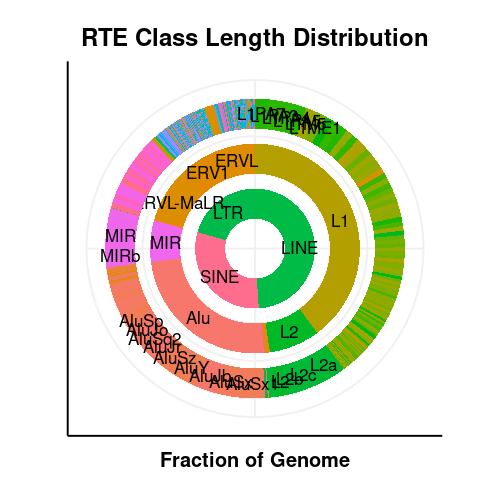

In [11]:
%%R
library(ggplot2)
df<-read.csv('../data/analysis/class_len.txt',sep='\t')
df$Fraction<-df$repLen/sum(df$repLen)
df$ymax<-cumsum(df$Fraction)
df$ymin<-c(0,head(df$ymax,-1))
df$labelPosition <- (df$ymax + df$ymin) / 2

df_fam<-read.csv('../data/analysis/family_len.txt',sep='\t')
df_fam$Fraction<-df_fam$repLen/sum(df_fam$repLen)
df_fam$ymax<-cumsum(df_fam$Fraction)
df_fam$ymin<-c(0,head(df_fam$ymax,-1))
df_fam$labelPosition <- (df_fam$ymax + df_fam$ymin) / 2

fam_names<-df_fam[df_fam$Fraction>0.03,]

df_subfam<-read.csv('../data/analysis/subfam_len.txt',sep='\t')
df_subfam$Fraction<-df_subfam$repLen/sum(df_subfam$repLen)
df_subfam$ymax<-cumsum(df_subfam$Fraction)
df_subfam$ymin<-c(0,head(df_subfam$ymax,-1))
df_subfam$labelPosition <- (df_subfam$ymax + df_subfam$ymin) / 2
subfam_names<-df_subfam[df_subfam$Fraction>0.01,]

pdf('../data/analysis/figures/len_dist.pdf',width=10,height=10)
p<-ggplot()+geom_rect(data=df,aes(ymax=ymax,ymin=ymin,xmax=4,xmin=2,fill=repClass))+ annotate('text',x=3, y=df$labelPosition, label=df$repClass, size=6) +
  geom_rect(data=df_fam,aes(ymax=ymax,ymin=ymin,xmax=7,xmin=5,fill=repFamily))+ annotate('text',x=6, y=fam_names$labelPosition, label=fam_names$repFamily, size=6) +
  geom_rect(data=df_subfam,aes(ymax=ymax,ymin=ymin,xmax=8,xmin=10,fill=repName))+ annotate('text',x=9, y=subfam_names$labelPosition, label=subfam_names$repName, size=6) +
  coord_polar(theta='y')+theme_void()+theme_Publication()+labs(title='RTE Class Length Distribution',x='',y='Fraction of Genome')+xlim(0,10)+
  theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(),  
        axis.ticks.y=element_blank(),
        legend.position='none'  
        )#+scale_fill_Publication()
print(p)
dev.off()
print(p)

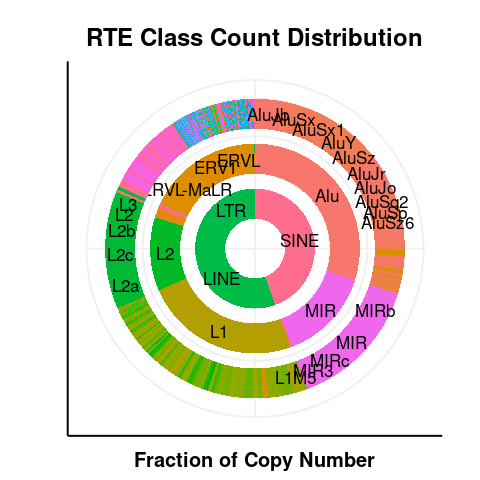

In [12]:
%%R
library(ggplot2)
df<-read.csv('../data/analysis/class_count.txt',sep='\t')
df$Fraction<-df$repLen/sum(df$repLen)
df$ymax<-cumsum(df$Fraction)
df$ymin<-c(0,head(df$ymax,-1))
df$labelPosition <- (df$ymax + df$ymin) / 2

df_fam<-read.csv('../data/analysis/family_count.txt',sep='\t')
df_fam$Fraction<-df_fam$repLen/sum(df_fam$repLen)
df_fam$ymax<-cumsum(df_fam$Fraction)
df_fam$ymin<-c(0,head(df_fam$ymax,-1))
df_fam$labelPosition <- (df_fam$ymax + df_fam$ymin) / 2

fam_names<-df_fam[df_fam$Fraction>0.03,]

df_subfam<-read.csv('../data/analysis/subfam_count.txt',sep='\t')
df_subfam$Fraction<-df_subfam$repLen/sum(df_subfam$repLen)
df_subfam$ymax<-cumsum(df_subfam$Fraction)
df_subfam$ymin<-c(0,head(df_subfam$ymax,-1))
df_subfam$labelPosition <- (df_subfam$ymax + df_subfam$ymin) / 2
subfam_names<-df_subfam[df_subfam$Fraction>0.01,]

pdf('../data/analysis/figures/count_dist.pdf',width=10,height=10)
p<-ggplot()+geom_rect(data=df,aes(ymax=ymax,ymin=ymin,xmax=4,xmin=2,fill=repClass))+ annotate('text',x=3, y=df$labelPosition, label=df$repClass, size=6) +
geom_rect(data=df_fam,aes(ymax=ymax,ymin=ymin,xmax=7,xmin=5,fill=repFamily))+ annotate('text',x=6, y=fam_names$labelPosition, label=fam_names$repFamily, size=6) +
geom_rect(data=df_subfam,aes(ymax=ymax,ymin=ymin,xmax=8,xmin=10,fill=repName))+  annotate('text',x=9, y=subfam_names$labelPosition, label=subfam_names$repName, size=6) +
coord_polar(theta='y')+theme_void()+theme_Publication()+labs(title='RTE Class Count Distribution',x='',y='Fraction of Copy Number')+xlim(0,10)+
  theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(),  
        axis.ticks.y=element_blank(),
        legend.position='none'  
        )
print(p)
dev.off()
print(p)

In [14]:
max_exp=None
region_count=defaultdict(lambda:defaultdict(int))
rtes=rmsk['repName'].unique()
cell_umaps={}
for dataset in datasets:
    print(dataset)
    df=all_dfs[dataset]
    df=pd.DataFrame(df,index=df.index,columns=df.columns)
    df.fillna(0,inplace=True)
    sum_=df.sum(axis=0).to_list()
    for i in range(len(df.columns)-2):
        gene=df.columns[i]
        if gene in gene_type:
            region_count[dataset][gene_type[gene]]+=sum_[i]
            
    drtes=df.loc[:,[x for x in df.columns if x in rtes]]
    mean_=drtes.mean(axis=0).to_list()
    poce=[np.count_nonzero(drtes.iloc[:,i]>1)/(1.0*len(drtes.index)) for i in range(len(drtes.columns))]

    tmp=pd.DataFrame([mean_,poce,[dataset]*len(drtes.columns),drtes.columns,[te_cls[x] for x in drtes.columns]],columns=drtes.columns,index=['Mean','PoE','Dataset','RTE','RTE_Fam']).transpose()

    tmp.sort_values(by='Mean',inplace=True,ascending=False)
    for fam in ['SINE','LINE','LTR']:
        if max_exp is None:
            max_exp=tmp.loc[tmp.RTE_Fam==fam,:]#.head(n=10)
        else:
            max_exp=pd.concat([max_exp,tmp.loc[tmp.RTE_Fam==fam,:]],ignore_index=True)
max_exp.sort_values(by=['Dataset','RTE_Fam','Mean'],ascending=False,inplace=True)
max_exp['Mean']=np.log1p(list(max_exp['Mean']))
max_exp.to_csv('../data/analysis/max_exp.txt',header=True,index=False,sep='\t')

AD_HS_00001
AD_HS_00003.1
AD_HS_00003.2
AD_HS_00004
AD_HS_00005
AD_HS_00006
AD_HS_00007


## TE read number

In [ ]:
count_df=pd.DataFrame(dict(region_count))
count_df=count_df[['AD_HS_00001','AD_HS_00002','AD_HS_00003.1','AD_HS_00003.2','AD_HS_00004','AD_HS_00005','AD_HS_00006','AD_HS_00007','AD_HS_00008','MS_HS_00001','MS_HS_00002','PD_HS_00001','PD_HS_00002']]
count_df=count_df.loc[['LINE','SINE','LTR'],:]

for dataset in count_df.columns:
    count_df[dataset]=count_df[dataset]/count_df[dataset].sum()
    
## read#, rte, dataset
ret=[]
for i in range(len(count_df)):
    for j in range(len(count_df.columns)):
        ret.append([count_df.iloc[i,j], count_df.index[i], count_df.columns[j]])
ret=pd.DataFrame(ret,columns=['Read#','RTE','Dataset'])
ret=ret.loc[ret['RTE'].isin(['LINE','SINE','LTR']),:]
ret.to_csv('../data/analysis/cls_read_proportion.txt',sep='\t',header=True,index=False)

In [ ]:
%%R
df<-read.csv('../data/analysis/cls_read_proportion.txt',sep='\t',header=T,)
df$RTE=factor(df$RTE,levels=c('SINE','LINE','LTR'))
p<-ggplot(df,aes(x=Dataset,y=Read.,Group=RTE,fill=RTE))+geom_bar(stat='identity',position='dodge')+labs(x='Dataset',y='Read Proportion')+theme_Publication()+theme(axis.text.x=element_text(angle=45,vjust=1,hjust=1))
print(p)
pdf('../data/analysis/figures/cls_read_proportion.pdf',width=7,height=7)
print(p)
dev.off()

## Counts of cells

In [ ]:
cells=['Ast','Ex','In','Oli','OPC','Endo','Mic','VLMC']
table=[]
for dataset in all_dfs.keys():
    print(dataset,end=',')
    umap=all_cell_umaps[dataset]
    tmp=[]
    for cell in cells:
        tmp.append(len(umap.loc[umap['predicted.celltype']==cell,:]))
    tmp.append(len(umap))
    table.append(tmp)
table=pd.DataFrame(table,index=all_dfs.keys())
table.columns=cells+['Total']
table

## Most expressed RTE

In [ ]:
%%R
most_exp<-read.csv("../data/analysis/max_exp.txt",sep='\t')
ps<-list()

for(cls in c('SINE','LINE','LTR')){
    df<-NULL
    sine_exp<-most_exp[most_exp$RTE_Fam==cls,]
    for(dataset in unique(sine_exp$Dataset)){
        tmp<-sine_exp[sine_exp$Dataset==dataset,]
        tmp<-tmp[1:10,]
        if(is.null(df)){
            df<-tmp
        }else{
            df<-rbind(df,tmp)
        }
    }
    df<-as.data.frame(df,colnames=colnames(sine_exp))
    df$RTE<-factor(df$RTE,levels=unique(df$RTE))
    p<-ggplot(df,aes(x=RTE,y=Dataset,size=PoE,color=Mean))+geom_point()+theme_Publication()+
        scale_size(range = c(1, 10))+theme(axis.text.x = element_text(angle = 60, hjust = 1))+xlab(paste0('Most expressed ',cls))
    ps[[length(ps)+1]]<-p
    print(p)
}
pdf("../data/analysis/figures/most_exp.pdf",width=7,height=7)
for(p in ps){
    plot(p)
}
dev.off()

In [ ]:
%%R
df_subfam<-read.csv('../data/analysis/subfam_len.txt',sep='\t')[,c(1,2)]
df_subfam<-df_subfam[order(df_subfam$repName,decreasing = T),]
df_subfam2<-read.csv('../data/analysis/subfam_count.txt',sep='\t')
df_subfam2<-df_subfam2[order(df_subfam2$repName,decreasing = T),]
df_subfam$Count<-df_subfam2$repLen
rownames(df_subfam)<-df_subfam$repName

df_subfam<-df_subfam[order(df_subfam$repName),]
most_exp$repLen<-0
most_exp$Count<-0
most_exp<-most_exp[order(most_exp$Dataset,most_exp$RTE),]
for(dataset in unique(most_exp$Dataset)){
    print(dataset)
    most_exp[most_exp$Dataset==dataset,]$repLen<-df_subfam[most_exp[most_exp$Dataset==dataset,'RTE'],]$repLen
    most_exp[most_exp$Dataset==dataset,]$Count<-df_subfam[most_exp[most_exp$Dataset==dataset,'RTE'],]$Count
}

In [ ]:
%%R
head(most_exp)
most_exp$repL_log<-log10(most_exp$repLen)
most_exp$count_log<-log10(most_exp$Count)
m1<-lm(Mean~repL_log,most_exp)
print(summary(m1))
m2<-lm(Mean~count_log,most_exp)
print(summary(m2))

In [ ]:
%%R
# predict using fitted model
most_exp$pred1<-predict(m1)
most_exp$pred2<-predict(m2)
most_exp[most_exp$RTE_Fam=='LINE' & most_exp$Mean>=4 & most_exp$repL_log<7,]

In [ ]:
%%R
library(MASS)
library(scales)
pdf('../data/analysis/figures/mean_exp_cor.pdf')
most_exp$RTE_Fam<-factor(most_exp$RTE_Fam,levels=c('SINE','LINE','LTR'))
p1<-ggplot(data=most_exp,aes(x=repLen,y=Mean,color=RTE_Fam))+geom_point()+theme_Publication()+scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
              labels = trans_format("log10", math_format(10^.x))) +ylab('Mean expression')+xlab('Total length')#+ theme(legend.position="none")
p2<-ggplot(data=most_exp,aes(x=Count,y=Mean,color=RTE_Fam))+geom_point()+theme_Publication()+scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
              labels = trans_format("log10", math_format(10^.x)))+ylab('Mean Expression') #+ theme(legend.position="none")
print(p1)
print(p2)
dev.off()
print(p1)
print(p2)